In [87]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

from datetime import datetime
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

In [88]:
!curl -O https://lazyprogrammer.me/course_files/timeseries/temperature.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
  1 3980k    1 63567    0     0  35308      0  0:01:55  0:00:01  0:01:54 35354
 38 3980k   38 1550k    0     0   570k      0  0:00:06  0:00:02  0:00:04  571k
100 3980k  100 3980k    0     0  1087k      0  0:00:03  0:00:03 --:--:-- 1088k


In [89]:
df=pd.read_csv('temperature.csv')

In [90]:
df.head()

,record_id,month,day,year,AverageTemperatureFahr,AverageTemperatureUncertaintyFahr,City,country_id,Country,Latitude,Longitude
0,474376,1,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E
1,474377,2,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E
2,474378,3,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E
3,474379,4,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E
4,474380,5,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E


Note that this data is not formatted in a way that is easy for us to process, we prefer to have month, day and year as a single datetime. 

We would like to have a data format T x D i.e. T rows and D columns. Lets choose 2 cities ( D=2) for simplicity. 

The data is not in this format since city is a column in itself.

We do the following to parse the data in our format

In [91]:
def parse_date(row):
    s=f"{row['year']}-{row['month']}-{row['day']}"
    return datetime.strptime(s,"%Y-%m-%d")

In [92]:
df['Date']=df.apply(parse_date,axis=1)

In [93]:
auckland=df[df['City']=='Auckland'].copy().dropna()
stockholm=df[df['City']=='Stockholm'].copy().dropna()

In [94]:
# Keep only columns we want
auckland=auckland[['Date','AverageTemperatureFahr']].copy()
stockholm=stockholm[['Date','AverageTemperatureFahr']].copy()

There may probably no relationship between these two cities, because they are so far apart. We will see if we can get this from the model

In [95]:
# Set index to date col
auckland.set_index(auckland['Date'],inplace=True)
auckland.drop('Date',axis=1,inplace=True)
auckland.columns=['AucklandTemp']

In [96]:
auckland.head()

,AucklandTemp
Date,
1853-06-01,51.9062
1853-07-01,52.3886
1853-08-01,52.8530
1853-09-01,52.5776
1853-10-01,54.8726


In [97]:
# Set index to date col
stockholm.set_index(stockholm['Date'],inplace=True)
stockholm.drop('Date',axis=1,inplace=True) # it is no longer needed
stockholm.columns=['StockholmTemp']

In [98]:
stockholm.head()

,StockholmTemp
Date,
1743-11-01,42.8414
1744-04-01,36.8888
1744-05-01,45.1220
1744-06-01,53.1824
1744-07-01,60.0260


In [99]:
joined=auckland.join(stockholm,how='outer') # has some missing data

In [100]:
joined.shape

(3155, 2)

Note that we have some missing data, specifically at the start of the table

3000 is a pretty large number for this type of analysis

Lets select the last 500 rows

In [101]:
joined_part=joined.iloc[-500:].copy()
joined_part.index.freq='MS'

In [102]:
joined_part.isna().sum()

AucklandTemp     1
StockholmTemp    4
dtype: int64

In [103]:
joined_part.interpolate(inplace=True) # Don't do it with stoock price
joined_part.isna().sum()


AucklandTemp     0
StockholmTemp    0
dtype: int64

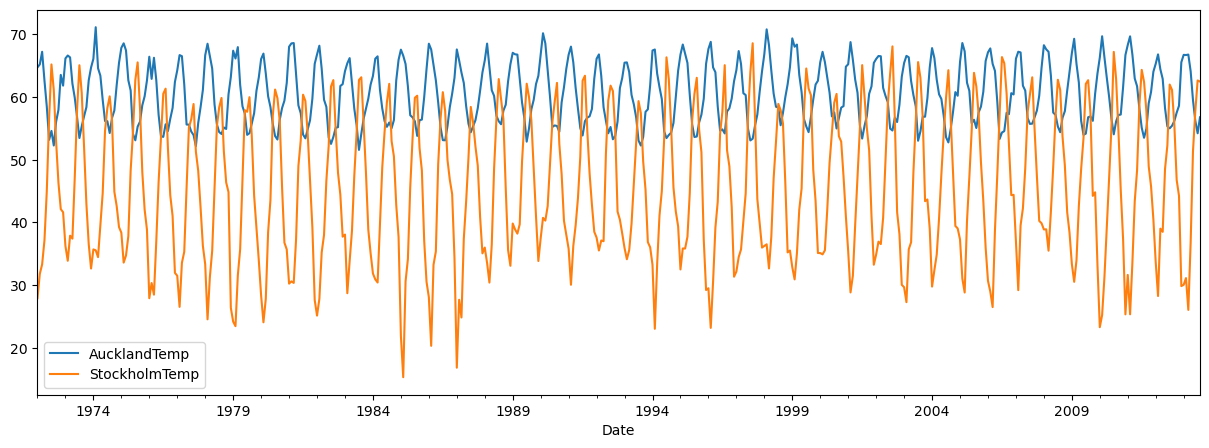

In [104]:
joined_part.plot(figsize=(15,5));

Notice that the temperature for the two cities are not on the same scale

Perhaps it is useful to scale this data.

Data is finally in the format we need

Next step is to split our data into train and test

In [105]:
Ntest =12
train=joined_part.iloc[:-Ntest].copy()
test=joined_part.iloc[-Ntest:].copy()

Next Step is to scale the data

In [106]:
scaler_auckland=StandardScaler()
train['ScaledAuckland']=scaler_auckland.fit_transform(
train[['AucklandTemp']])
test['ScaledAuckland']=scaler_auckland.transform(test[['AucklandTemp']])

In [107]:
scaler_stockholm=StandardScaler()
train['ScaledStockholm']=scaler_stockholm.fit_transform(
train[['StockholmTemp']])
test['ScaledStockholm']=scaler_stockholm.transform(test[['StockholmTemp']])

Next Step is to index our original dataframe for both train and test set

In [108]:
train_idx=joined_part.index<=train.index[-1]
test_idx=joined_part.index>train.index[-1]

In [109]:
# Put them back iin the original df
joined_part.loc[train_idx,'ScaledAuckland']=train['ScaledAuckland']
joined_part.loc[test_idx,'ScaledAuckland']=test['ScaledAuckland']
joined_part.loc[train_idx,'ScaledStockholm']=train['ScaledStockholm']
joined_part.loc[test_idx,'ScaledStockholm']=test['ScaledStockholm']

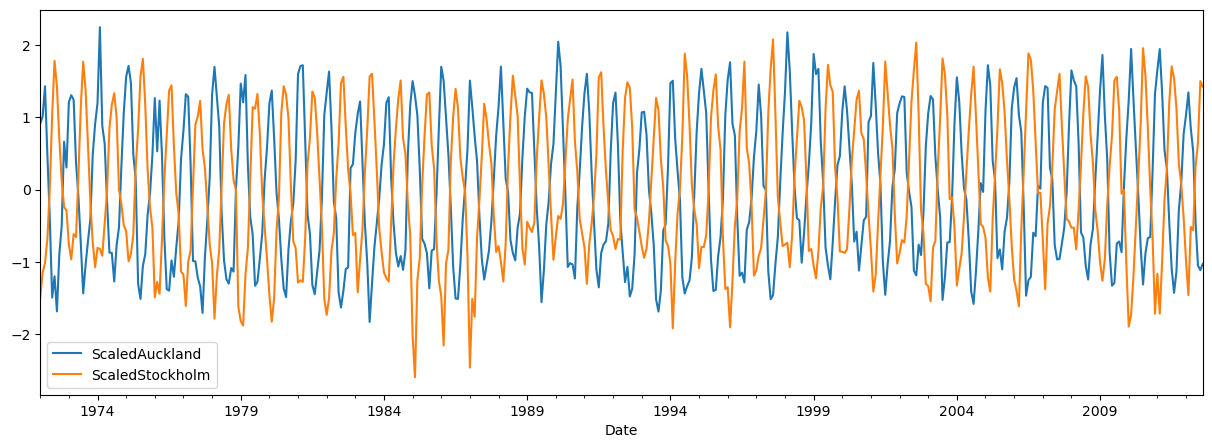

In [110]:
cols=['ScaledAuckland','ScaledStockholm']
train[cols].plot(figsize=(15,5));

As we can see the two timeseries are in the same scale

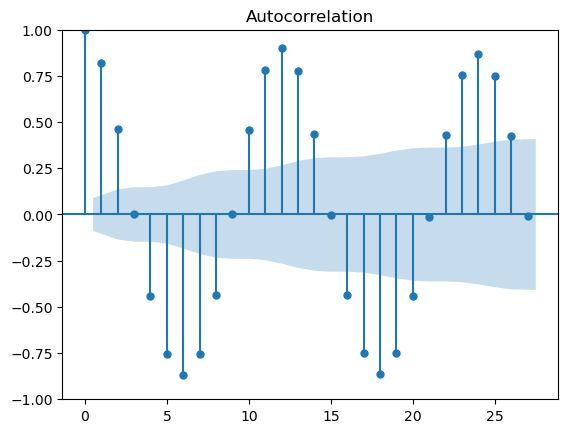

In [111]:
plot_acf(train['ScaledAuckland']);

ACF has a strong seasonal pattern because the time series itself has a strong seasonal pattern

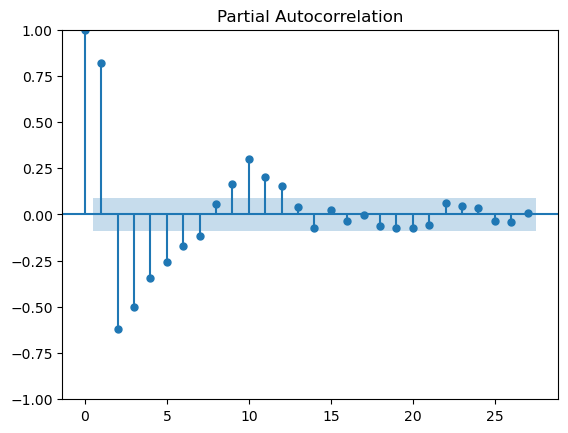

In [112]:
plot_pacf(train['ScaledAuckland']);

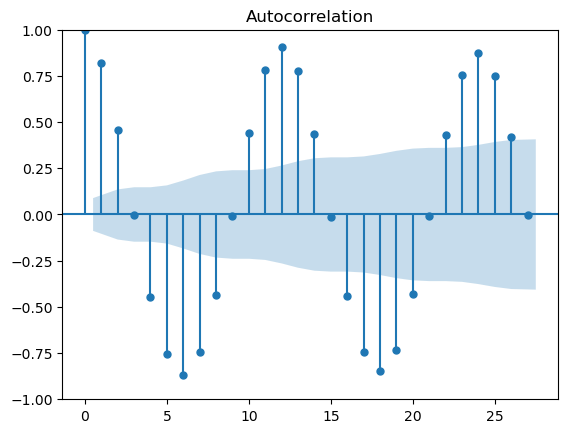

In [113]:
plot_acf(train['ScaledStockholm']);

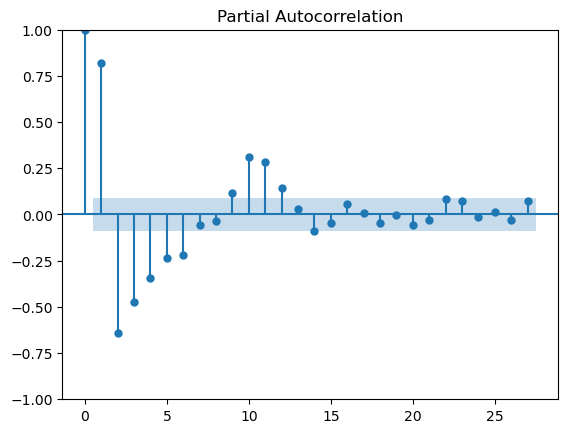

In [114]:
plot_pacf(train['ScaledStockholm']);

Again we see a similar period Pattern

Now lets create a VARMAX object and fit into a time series. It will take some time.

p=10 and q=10 is taken for no particular reason. 

In [115]:
t0=datetime.now()
model=VARMAX(train[cols],order=(10,10))
res=model.fit(maxiter=100)
print("Duration",datetime.now()-t0)

C:\Users\asus\anaconda31\Lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
C:\Users\asus\anaconda31\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Duration 0:06:32.334881


In [116]:
fcast=res.get_forecast(Ntest)

In [117]:
res.fittedvalues['ScaledAuckland']

Date
1972-01-01   -0.006905
1972-02-01    0.825273
1972-03-01    0.716527
1972-04-01    0.813218
1972-05-01   -0.081169
                ...   
2012-04-01    0.518177
2012-05-01   -0.294998
2012-06-01   -1.069465
2012-07-01   -1.335462
2012-08-01   -1.067613
Freq: MS, Name: ScaledAuckland, Length: 488, dtype: float64

In [118]:
joined_part.loc[train_idx,'Train Pred Auckland']=\
res.fittedvalues['ScaledAuckland']

joined_part.loc[test_idx,'Test Pred Auckland']=\
fcast.predicted_mean['ScaledAuckland']

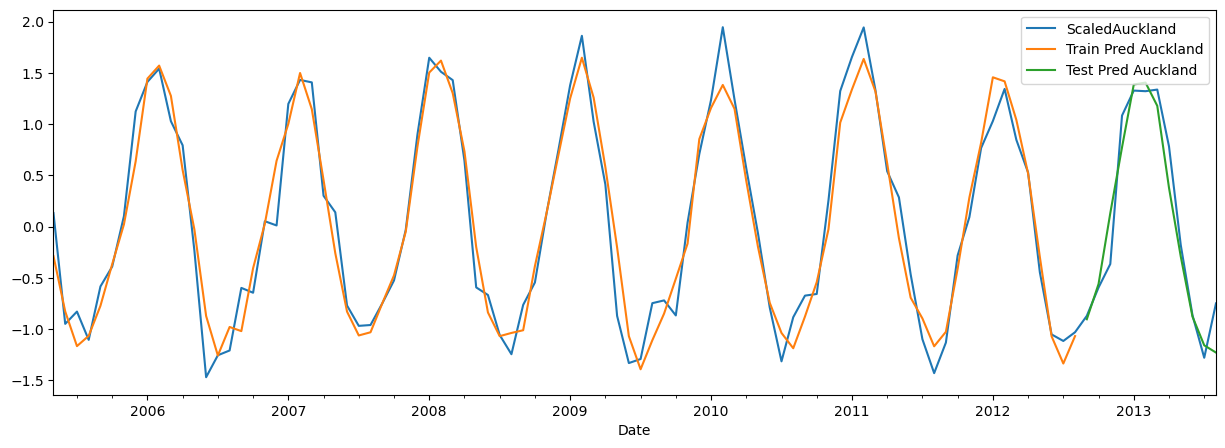

In [119]:
plot_cols=['ScaledAuckland','Train Pred Auckland','Test Pred Auckland']
joined_part.iloc[-100:][plot_cols].plot(figsize=(15,5));

In [120]:
joined_part.loc[train_idx,'Train Pred Stockholm']=\
res.fittedvalues['ScaledStockholm']

joined_part.loc[test_idx,'Test Pred Stockholm']=\
fcast.predicted_mean['ScaledStockholm']

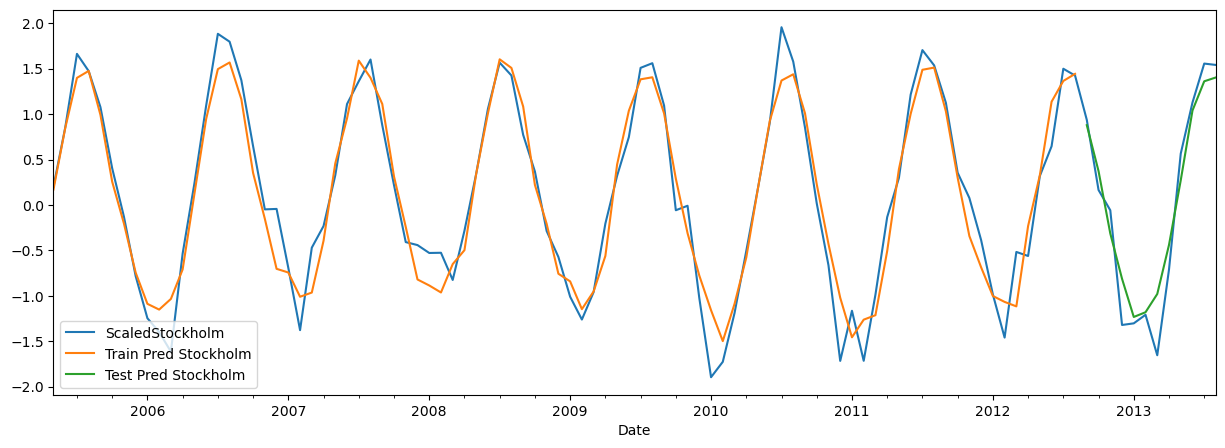

In [121]:
plot_cols=['ScaledStockholm','Train Pred Stockholm','Test Pred Stockholm']
joined_part.iloc[-100:][plot_cols].plot(figsize=(15,5));

Lets Check the r-squre of our model

In [122]:
y_pred=joined_part.loc[train_idx,'Train Pred Auckland']
y_true=joined_part.loc[train_idx,'ScaledAuckland']
print('Auckland Train R^2:',r2_score(y_true,y_pred))

y_pred=joined_part.loc[test_idx,'Test Pred Auckland']
y_true=joined_part.loc[test_idx,'ScaledAuckland']
print('Auckland Test R^2:',r2_score(y_true,y_pred))

Auckland Train R^2: 0.9295058168143944
Auckland Test R^2: 0.9286986010638731


In [123]:
print(joined_part.loc[train_idx,'Train Pred Stockholm'].isnull().sum())
print(joined_part.loc[train_idx,'ScaledStockholm'].isnull().sum())
print(joined_part.loc[test_idx,'Test Pred Stockholm'].isnull().sum())
print(joined_part.loc[test_idx,'ScaledStockholm'].isnull().sum())

0
0
0
0


In [124]:
y_pred=joined_part.loc[train_idx,'Train Pred Stockholm']
y_true=joined_part.loc[train_idx,'ScaledStockholm']
print('Stockholm Train R^2:',r2_score(y_true,y_pred))

y_pred=joined_part.loc[test_idx,'Test Pred Stockholm']
y_true=joined_part.loc[test_idx,'ScaledStockholm']
print('Stockholm Test R^2:',r2_score(y_true,y_pred))

Stockholm Train R^2: 0.9247031535978733
Stockholm Test R^2: 0.9315856768400342


## VAR

Vector Auto Regression

We start by creating a VAR object. Note that at this point we do not pass 'p'

In [125]:
model = VAR(train[cols])

You can select any value eg. maxlags=15 are chosen. You can see that this returns a LagOrderResults object

In [126]:
lag_order_results=model.select_order(maxlags=15)
lag_order_results

The next is to print out the selected order attributes

In [127]:
lag_order_results.selected_orders

{'aic': 12, 'bic': 6, 'hqic': 11, 'fpe': 12}

Key is the criterion and value is the order chosen if we take that criterion. Notice that they do not all agree

In [128]:
results=model.fit(maxlags=15,ic='aic')

Here we are getting the lag order chosen by the AIC

In [129]:
lag_order=results.k_ar

In [130]:
prior=train.iloc[-lag_order:][cols].to_numpy() # why need this ?
fcast=results.forecast(prior,Ntest)

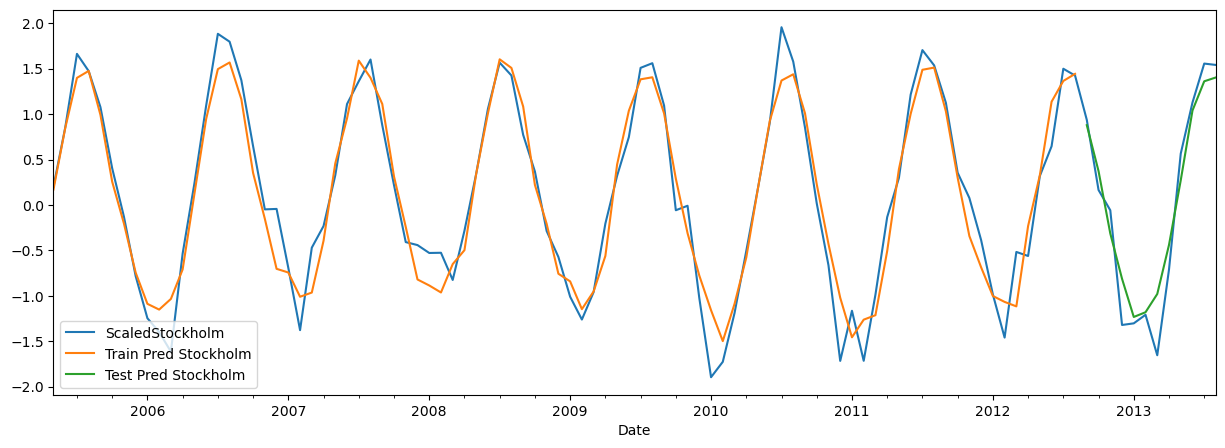

In [131]:
joined_part.loc[train_idx,'Train Pred Auckland']=\
results.fittedvalues['ScaledAuckland']
joined_part.loc[test_idx,'Test Pred Auckland']=\
fcast[:,0]

plt_cols=['ScaledAuckland','Train Pred Auckland','Test Pred Auckland']
joined_part.iloc[-100:][plot_cols].plot(figsize=(15,5));

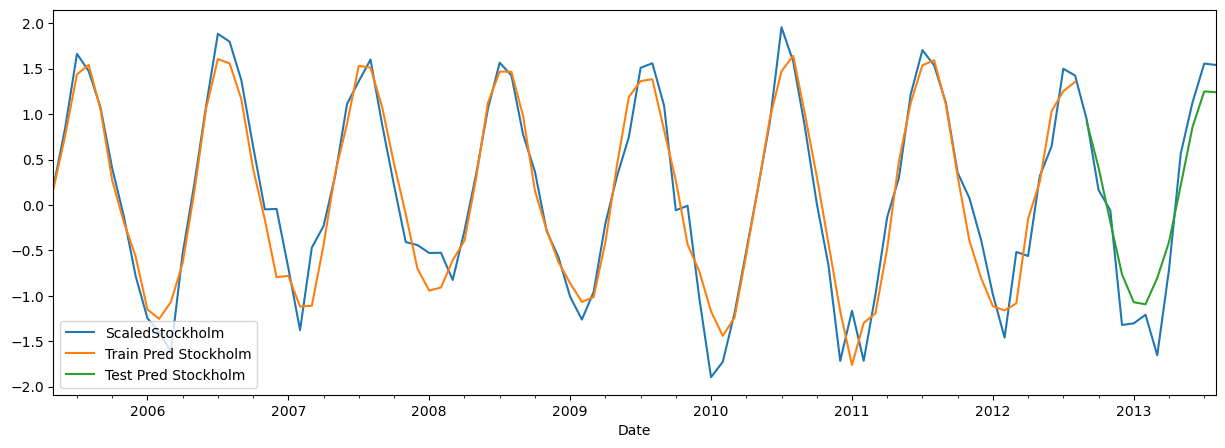

In [133]:
joined_part.loc[train_idx,'Train Pred Stockholm']=\
results.fittedvalues['ScaledStockholm']

joined_part.loc[test_idx,'Test Pred Stockholm']=\
fcast[:,1]

plot_cols=['ScaledStockholm','Train Pred Stockholm','Test Pred Stockholm']
joined_part.iloc[-100:][plot_cols].plot(figsize=(15,5));

In [135]:
y_pred=joined_part.loc[train_idx,'Train Pred Auckland']
y_true=joined_part.loc[train_idx,'ScaledAuckland']
y_true=y_true.iloc[lag_order:]
y_pred=y_pred.iloc[lag_order:]
print('Auckland Train R^2:',r2_score(y_true,y_pred))

y_pred=joined_part.loc[test_idx,'Test Pred Auckland']
y_true=joined_part.loc[test_idx,'ScaledAuckland']
print('Auckland Test R^2:',r2_score(y_true,y_pred))

Auckland Train R^2: 0.921070700106029
Auckland Test R^2: 0.9233643831340892


In [136]:
y_pred=joined_part.loc[train_idx,'Train Pred Stockholm']
y_true=joined_part.loc[train_idx,'ScaledStockholm']
y_true=y_true.iloc[lag_order:]
y_pred=y_pred.iloc[lag_order:]
print('Stockholm Train R^2:',r2_score(y_true,y_pred))

y_pred=joined_part.loc[test_idx,'Test Pred Stockholm']
y_true=joined_part.loc[test_idx,'ScaledStockholm']
print('Stockholm Test R^2:',r2_score(y_true,y_pred))

Stockholm Train R^2: 0.9267030553588321
Stockholm Test R^2: 0.8930437688204876


### ARIMA as a Baseline

In [137]:
from statsmodels.tsa.arima.model import ARIMA

In [138]:
for col in cols:
    model=ARIMA(train[col],order=(10,0,10))
    res=model.fit()
    fcast=res.get_forecast(Ntest)
    print(f"{col} Train R^2:", r2_score(joined_part.loc[train_idx, col], res.fittedvalues))
    print(f"{col} Test R^2:", r2_score(joined_part.loc[test_idx, col], fcast.predicted_mean))

C:\Users\asus\anaconda31\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ScaledAuckland Train R^2: 0.9213759532259058
ScaledAuckland Test R^2: 0.9380664694304495


C:\Users\asus\anaconda31\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ScaledStockholm Train R^2: 0.9207112758311619
ScaledStockholm Test R^2: 0.948051577550766


As ARIMA do not have any cross terms, we can see that these two cities are independent 